In [1]:
#needs jetq-coffea environment

from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
#import fastjet
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import re

import warnings
warnings.filterwarnings("ignore")

import sys

#sys.path.append("/uscms_data/d3/azhou/smeft/hbb-run3/src")
#sys.path.append('~/nobackup/smeft/topcoffea')
#from hbb.utils import load_samples, get_sum_genweights
#from hbb.processors.categorizer import add_weights, get_dataset_norm
import pickle
import uproot
import json

import os
import argparse
from coffea.nanoevents import NanoEventsFactory
from topcoffea.scripts.make_html import make_html
from topcoffea.modules import utils
import topcoffea.modules.quad_fit_tools as qft

In [2]:
start0_sample = "/uscms/home/azhou/nobackup/smeft/jennet_files/vbf_rw_start0_5000.root"
start1_sample = "/uscms/home/azhou/nobackup/smeft/jennet_files/vbf_rw_start1_5000.root"

cHW_sample = "/uscms/home/azhou/nobackup/smeft/jennet_files/VBF_SMEFTsim_topU3l_Direct_cHW_HT2/VBFH_SMEFTsim_100.root"
cHWtil_sample = "/uscms/home/azhou/nobackup/smeft/jennet_files/VBF_SMEFTsim_topU3l_Direct_cHWtil_HT2/VBFH_SMEFTsim_101.root"
cHj3_sample = "./VBFH_SMEFTsim_1.root"
cHbox_sample = "./VBFH_SMEFTsim_2.root"

#check contents of root:
to_open = uproot.open(start0_sample)
print(to_open.keys())

['tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [3]:
start0_events = NanoEventsFactory.from_root(
    {start0_sample:"/Events"},
    schemaclass=PFNanoAODSchema,
    mode='eager'
).events()

start1_events = NanoEventsFactory.from_root(
    {start1_sample:"/Events"},
    schemaclass=PFNanoAODSchema,
    mode='eager'
).events()

cHW_events = NanoEventsFactory.from_root(
    {cHW_sample:"/Events"},
    schemaclass=PFNanoAODSchema,
    mode='eager'
).events()

cHWtil_events = NanoEventsFactory.from_root(
    {cHWtil_sample:"/Events"},
    schemaclass=PFNanoAODSchema,
    mode='eager'
).events()

cHj3_events = NanoEventsFactory.from_root(
    {cHj3_sample:"/Events"},
    schemaclass=PFNanoAODSchema,
    mode='eager'
).events()

cHbox_events = NanoEventsFactory.from_root(
    {cHbox_sample:"/Events"},
    schemaclass=PFNanoAODSchema,
    mode='eager'
).events()

In [4]:
wc_list = ['cHbox',
           'cHDD',
           'cHW',
           'cHB',
           'cHWB',
           'cuWRe',
           'cuBRe',
           'cdWRe',
           'cdBRe',
           'cHj1',
           'cHj3',
           'cHu',
           'cHd',
           'cHudRe',
           'cHWtil',
           'cHBtil',
           'cHWBtil',
           'cuWIm',
           'cuBIm',
           'cdWIm',
           'cdBIm',
           'cHudIm']

In [5]:
start0 = {}
start1 = {}

for op in wc_list:
    start0[op] = 0
    start1[op] = 1

In [6]:
def hist_and_err(values, weights, bins):
    hist, edges = np.histogram(values, bins=bins, weights=weights)
    hist_sq, _ = np.histogram(values, bins=bins, weights=weights**2)
    err = np.sqrt(hist_sq)
    centers = 0.5 * (edges[1:] + edges[:-1])
    return hist, err, centers

In [7]:
nbins = 25
max_pt = 500
bins = np.linspace(0, 500, nbins)

In [8]:
def reweight_jennet(events, wc_target, ax):

    higgses = events.LHEPart[events.LHEPart.pdgId == 25]
    h_pt = ak.firsts(higgses.pt)

    ax[0].hist(h_pt, weights=events.genWeight, bins=bins, histtype='step',color='tab:blue',label="SM")
    hist, err, centers = hist_and_err(h_pt, events.genWeight, bins)
    print(hist)
    ax[0].errorbar(x=centers, y=hist, yerr=err, linestyle='',color='tab:blue')
    ax[1].hist(centers, weights=hist/hist, bins=bins, histtype='step',color='tab:blue',label="SM")
    ax[1].errorbar(x=centers, y=hist/hist, yerr=err/hist, linestyle='',color='tab:blue')

    #print(events.fields)
    #print(events.WCnames)
    #print(events.EFTfitCoefficients)

    scale_factors = [0]*nbins
    for b in range(nbins - 1):
        mask = (h_pt >= bins[b]) & (h_pt < bins[b+1])
        events_in_bin = events[mask]
    
        #perform fit only on events in this bin
        if len(events_in_bin) == 0:
            print("empty bin")
            continue  # skip empty bins
    
        wc_fit_arr = qft.get_summed_quad_fit_arr(events_in_bin)
        if len(wc_fit_arr) == 0: #skip empty wc_fit_arrays
            print("empty wc fit array")
            continue 


        
        wc_fit_dict = qft.get_quad_fit_dict(wc_list, wc_fit_arr)
        #print(wc_fit_dict)
        wc_fit_dict = qft.scale_to_sm(wc_fit_dict)


        #coeffs = list(wc_fit_dict.values())
        #coeffs[np.argmax(coeffs)] = 0
        #print(max(coeffs))

        for op1 in list(wc_target.keys()):

            scale_factors[b] += wc_target[op1]*wc_target[op1]*wc_fit_dict[op1+'*'+op1]
            
            for op2 in list(wc_target.keys()):

                if op1 == op2:
                    continue
                    
                if op1+'*'+op2 in list(wc_fit_dict.keys()):
                    #print(op1,op2,wc_fit_dict[op1+'*'+op2])

                    #if wc_target[op1] > 0 and wc_target[op2] > 0:
                    #    print(op1,op2,wc_target[op1]*wc_target[op2]*wc_fit_dict[op1+'*'+op2])
                    scale_factors[b] += wc_target[op1]*wc_target[op2]*wc_fit_dict[op1+'*'+op2]

    #hist_pt = plt.hist(h_pt,histtype='step')
    #print(hist_pt)

    print(scale_factors)
    new_h_pt = [scale_factors[i]*hist[i] for i in range(nbins-1)]
    ax[0].hist(x=centers,weights=new_h_pt, bins=bins,histtype='step',color='tab:orange',label="RW")
    ax[1].hist(x=centers,weights=new_h_pt/hist, bins=bins,histtype='step',color='tab:orange',label="RW")

    return hist
    

target = start0.copy()
target['sm'] = 1.0
target['cHj3'] = 1.0

fig, ax = plt.subplots(2,1)

print(target.keys())
sm_hist = reweight_jennet(start0_events,target, ax=ax)

# Compare to direct sim
higgses = cHW_events.LHEPart[cHW_events.LHEPart.pdgId == 25]
h_pt = ak.firsts(higgses.pt)

print(len(start0_events),len(cHj3_events))

print(cHj3_events.genWeight)

ax[0].hist(h_pt, weights=cHj3_events.genWeight, bins=bins, histtype='step',color='tab:green',label="DIR")
hist, err, centers = hist_and_err(h_pt, cHj3_events.genWeight, bins)
ax[0].errorbar(x=centers, y=hist, yerr=err, linestyle='',color='tab:green')
ax[0].set_yscale('log')

ax[1].hist(centers, weights=hist/sm_hist, bins=bins, histtype='step',color='tab:green',label="DIR")
ax[1].errorbar(x=centers, y=hist/sm_hist, yerr=err/sm_hist, linestyle='',color='tab:green')

dict_keys(['cHbox', 'cHDD', 'cHW', 'cHB', 'cHWB', 'cuWRe', 'cuBRe', 'cdWRe', 'cdBRe', 'cHj1', 'cHj3', 'cHu', 'cHd', 'cHudRe', 'cHWtil', 'cHBtil', 'cHWBtil', 'cuWIm', 'cuBIm', 'cdWIm', 'cdBIm', 'cHudIm', 'sm'])
[1.02e+03, 2.55e+03, 3.21e+03, 2.87e+03, 2.42e+03, ..., 10.9, 7.27, 0, 0, 7.27]
empty bin
empty bin
[np.float32(0.99982864), np.float32(0.999792), np.float32(1.0006045), np.float32(1.0001088), np.float32(1.000285), np.float32(0.99752694), np.float32(0.99759346), np.float32(0.9962942), np.float32(1.0222349), np.float32(1.0281337), np.float32(0.9868737), np.float32(0.98362654), np.float32(0.99324256), np.float32(1.0459225), np.float32(1.0404913), np.float32(0.94831645), np.float32(1.012926), np.float32(1.0002928), np.float32(0.99994284), np.float32(1.0694702), np.float32(1.2961893), 0, 0, np.float32(0.8177314), 0]


<ErrorbarContainer object of 3 artists>

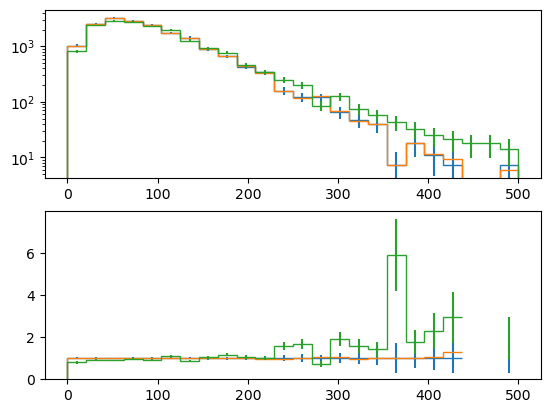

In [10]:
target = start0.copy()
target['sm'] = 1.0
target['cHW'] = 1.0

fig, ax = plt.subplots(2,1)

print(target.keys())
sm_hist = reweight_jennet(start0_events,target, ax=ax)

# Compare to direct sim
higgses = cHW_events.LHEPart[cHW_events.LHEPart.pdgId == 25]
h_pt = ak.firsts(higgses.pt)

ax[0].hist(h_pt, weights=cHW_events.genWeight, bins=bins, histtype='step',color='tab:green',label="DIR")
hist, err, centers = hist_and_err(h_pt, cHW_events.genWeight, bins)
ax[0].errorbar(x=centers, y=hist, yerr=err, linestyle='',color='tab:green')
ax[0].set_yscale('log')

ax[1].hist(centers, weights=hist/sm_hist, bins=bins, histtype='step',color='tab:green',label="DIR")
ax[1].errorbar(x=centers, y=hist/sm_hist, yerr=err/sm_hist, linestyle='',color='tab:green')

dict_keys(['cHbox', 'cHDD', 'cHW', 'cHB', 'cHWB', 'cuWRe', 'cuBRe', 'cdWRe', 'cdBRe', 'cHj1', 'cHj3', 'cHu', 'cHd', 'cHudRe', 'cHWtil', 'cHBtil', 'cHWBtil', 'cuWIm', 'cuBIm', 'cdWIm', 'cdBIm', 'cHudIm', 'sm'])
[1.02e+03, 2.55e+03, 3.21e+03, 2.87e+03, 2.42e+03, ..., 10.9, 7.27, 0, 0, 7.27]
empty bin
empty bin
[np.float32(1.0043448), np.float32(1.0015754), np.float32(1.0034001), np.float32(1.0007632), np.float32(1.0185025), np.float32(1.0202441), np.float32(1.0592251), np.float32(1.0338469), np.float32(1.129909), np.float32(1.1881251), np.float32(1.0177494), np.float32(1.1387708), np.float32(0.988922), np.float32(1.6049681), np.float32(1.0775925), np.float32(1.3935686), np.float32(1.5732198), np.float32(1.7929493), np.float32(0.46988183), np.float32(1.3399792), np.float32(1.5001405), 0, 0, np.float32(0.74894387), 0]


<ErrorbarContainer object of 3 artists>

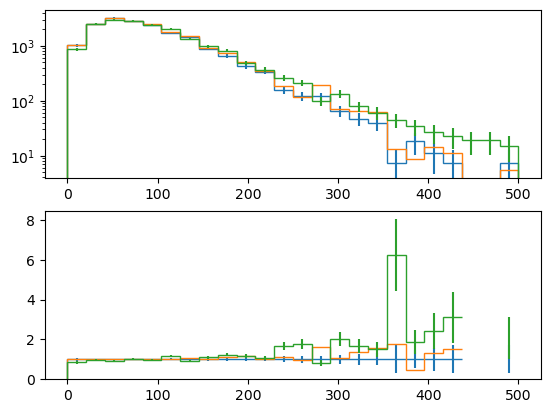

In [11]:
target = start0.copy()
target['sm'] = 1.0
target['cHWtil'] = 1.0

fig, ax = plt.subplots(2,1)

print(target.keys())
sm_hist = reweight_jennet(start0_events,target, ax=ax)

# Compare to direct sim
higgses = cHW_events.LHEPart[cHW_events.LHEPart.pdgId == 25]
h_pt = ak.firsts(higgses.pt)

ax[0].hist(h_pt, weights=cHWtil_events.genWeight, bins=bins, histtype='step',color='tab:green',label="DIR")
hist, err, centers = hist_and_err(h_pt, cHWtil_events.genWeight, bins)
ax[0].errorbar(x=centers, y=hist, yerr=err, linestyle='',color='tab:green')
ax[0].set_yscale('log')

ax[1].hist(centers, weights=hist/sm_hist, bins=bins, histtype='step',color='tab:green',label="DIR")
ax[1].errorbar(x=centers, y=hist/sm_hist, yerr=err/sm_hist, linestyle='',color='tab:green')

dict_keys(['cHbox', 'cHDD', 'cHW', 'cHB', 'cHWB', 'cuWRe', 'cuBRe', 'cdWRe', 'cdBRe', 'cHj1', 'cHj3', 'cHu', 'cHd', 'cHudRe', 'cHWtil', 'cHBtil', 'cHWBtil', 'cuWIm', 'cuBIm', 'cdWIm', 'cdBIm', 'cHudIm', 'sm'])
[1.02e+03, 2.55e+03, 3.21e+03, 2.87e+03, 2.42e+03, ..., 10.9, 7.27, 0, 0, 7.27]
empty bin
empty bin
[np.float32(0.99999994), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(0.99999994), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), 0, 0, np.float32(1.0), 0]
1.1233816665725769


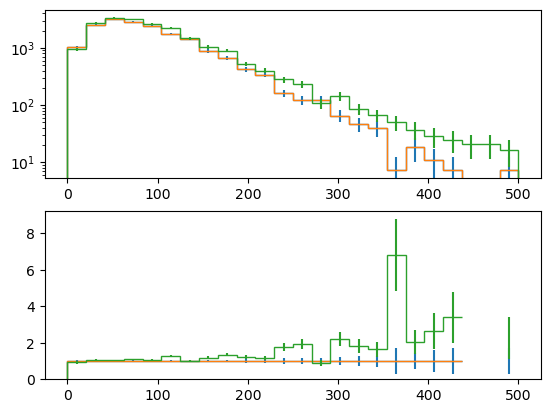

In [14]:
target = start0.copy()
target['sm'] = 1.0
target['cHbox'] = 1.0

fig, ax = plt.subplots(2,1)

print(target.keys())
sm_hist = reweight_jennet(start0_events,target, ax=ax)

# Compare to direct sim
higgses = cHW_events.LHEPart[cHW_events.LHEPart.pdgId == 25]
h_pt = ak.firsts(higgses.pt)

ax[0].hist(h_pt, weights=cHbox_events.genWeight, bins=bins, histtype='step',color='tab:green',label="DIR")
hist, err, centers = hist_and_err(h_pt, cHbox_events.genWeight, bins)
ax[0].errorbar(x=centers, y=hist, yerr=err, linestyle='',color='tab:green')
ax[0].set_yscale('log')

ax[1].hist(centers, weights=hist/sm_hist, bins=bins, histtype='step',color='tab:green',label="DIR")
ax[1].errorbar(x=centers, y=hist/sm_hist, yerr=err/sm_hist, linestyle='',color='tab:green')

print(np.sum(hist)/np.sum(sm_hist))